<a href="https://colab.research.google.com/github/subhamadhikari/human_emotion_detection/blob/main/HumanEmotionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix,roc_curve
import cv2
import seaborn as sns
import io
import os
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,GlobalAveragePooling2D,Conv2D,MaxPool2D,Dense,Flatten,InputLayer,BatchNormalization,Add
from tensorflow.keras.layers import Input,Dropout,RandomFlip,RandomRotation,Rescaling,Resizing,RandomContrast,Activation,MaxPooling2D
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback,CSVLogger,EarlyStopping,LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.regularizers import L2,L1
from tensorflow.keras.metrics import CategoricalAccuracy,TopKCategoricalAccuracy
from tensorflow.train import BytesList,FloatList,Int64List
from tensorflow.train import Example,Features,Feature
from google.colab import drive,files


#Data Management

##Data Downloading

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
# giving user the read and write permission
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

 99% 305M/309M [00:03<00:00, 153MB/s]
100% 309M/309M [00:03<00:00, 92.2MB/s]


In [ ]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

## Dataset Loading

In [ ]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
validation_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"

CLASS_NAME = ['angry','happy','sad']

CONFIGURATION = {
    "IM_SIZE":256,
    "BATCH_SIZE":32,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels="inferred",
    label_mode="categorical",
    class_names=CLASS_NAME,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99
)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_directory,
    labels="inferred",
    label_mode="categorical",
    class_names=CLASS_NAME,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99
)

Found 6799 files belonging to 3 classes.
Found 2278 files belonging to 3 classes.


## Data Visualization

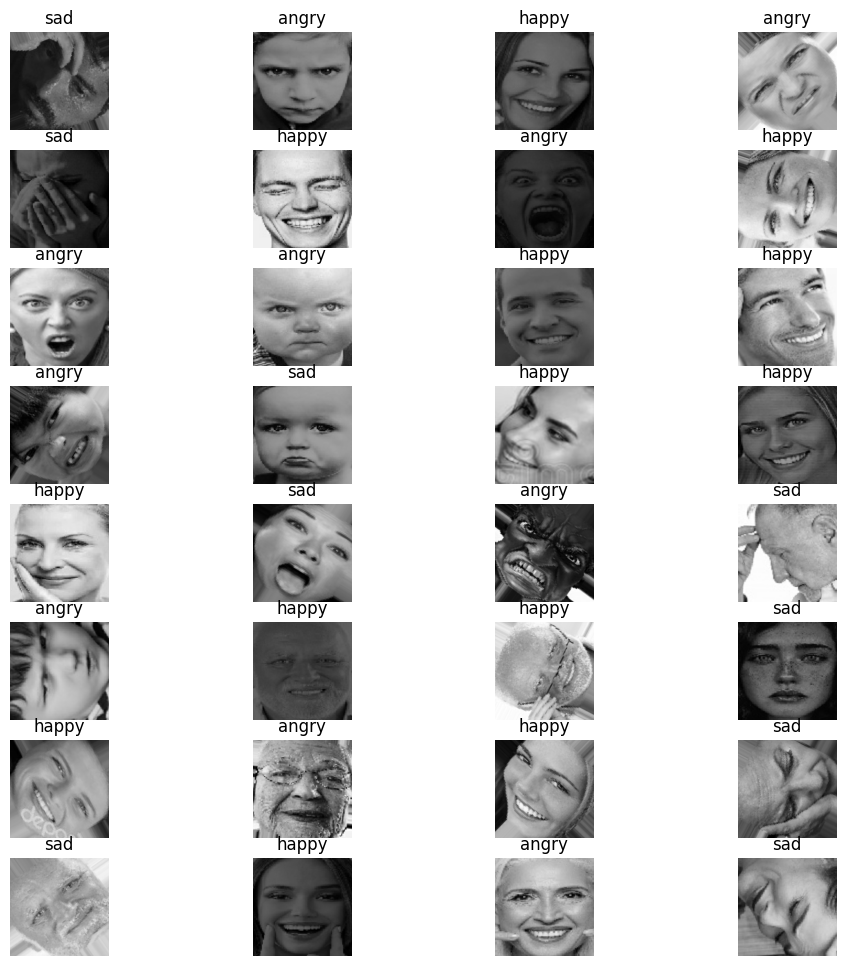

In [ ]:
plt.figure(figsize=(12,12))

for images,labels in train_dataset.take(1):
  for i in range(32):
    ax = plt.subplot(8,4,i+1)
    plt.imshow(images[i]/255)
    plt.title(CLASS_NAME[tf.argmax(labels[i],axis=0).numpy()])
    plt.axis('off')


##Data Augmentation

In [ ]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor=(-0.25,0.025)),
    RandomFlip(mode='horizontal'),
    RandomContrast(factor=0.1)
])

In [ ]:
def augment_layer(image,label):
  return augment_layers(image,training=True),label

### Cutmix

In [ ]:
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w


In [ ]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(2,2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

## Data Preparation

In [ ]:
train_dataset_1 = train_dataset.map(augment_layer,num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(augment_layer,num_parallel_calls=tf.data.AUTOTUNE)
mixed_dataset = tf.data.Dataset.zip((train_dataset_1,train_dataset_2))

In [ ]:
# training_dataset = (
#     mixed_dataset
#     .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
#     # .prefetch(tf.data.AUTOTUNE)
# )

In [ ]:
training_dataset = (
    train_dataset
    .map(augment_layer,num_parallel_calls=tf.data.AUTOTUNE)
    # .prefetch(tf.data.AUTOTUNE)
)
validation_dataset = (
    val_dataset
    # .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]),
    Rescaling(1./255)
])

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

#Modeling

## Lenet Model

In [ ]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape=(None,None,3)),
    resize_rescale_layers,

    Conv2D(filters=CONFIGURATION['N_FILTERS'],kernel_size=CONFIGURATION['KERNEL_SIZE'],
           strides=CONFIGURATION['N_STRIDES'],activation='relu',
           kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGURATION['POOL_SIZE'],strides=CONFIGURATION['N_STRIDES']*2),
    Dropout(rate=CONFIGURATION['DROPOUT_RATE']),

    Conv2D(filters=CONFIGURATION['N_FILTERS']*2+4,kernel_size=CONFIGURATION['KERNEL_SIZE'],
           strides=CONFIGURATION['N_STRIDES'],activation='relu',
           kernel_regularizer=L2(CONFIGURATION['REGULARIZATION_RATE'])),
    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGURATION['POOL_SIZE'],strides=CONFIGURATION['N_STRIDES']*2),
    Dropout(rate=CONFIGURATION['DROPOUT_RATE']),

    Flatten(),

    Dense(CONFIGURATION["N_DENSE_1"],activation='relu',
          kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dense(CONFIGURATION["N_DENSE_2"],activation='relu',
          kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dense(CONFIGURATION["NUM_CLASSES"],activation='softmax'),
])
# lenet_model.summary()

## ResNet34

### CustomConv2D

In [ ]:
class CustomConv2D(Layer):
  def __init__(self,n_filters,kernel_size,n_strides,padding='valid'):
    super(CustomConv2D,self).__init__(name='custom_conv2d')

    self.conv = Conv2D(
        filters=n_filters,
        kernel_size=kernel_size,
        activation='relu',
        strides=n_strides,
        padding=padding
    )
    self.batch_norm = BatchNormalization()

  def call(self,x,training=True):
    x = self.conv(x)
    x = self.batch_norm(x,training)

    return x

###Residual Block

In [ ]:
class ResidualBlock(Layer):
  def __init__(self,n_channels,n_strides=1):
    super(ResidualBlock,self).__init__(name="res_block")

    self.dotted = (n_strides!=1)

    self.custom_conv_1 = CustomConv2D(n_channels,3,n_strides,padding='same')
    self.custom_conv_2 = CustomConv2D(n_channels,3,1,padding='same')

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels,1,n_strides)

    def call(self,input,training):
      x = self.custom_conv_1(input,training)
      x = self.custom_conv_2(x,training)

      if self.dotted:
        x_add = self.custom_conv_3(input,training)
        x_add = Add()([x,x_add])
      else:
        x_add = Add()([x,input])

      return self.activation(x_add)

### Complete Network

In [ ]:
class ResNet34(Model):
  def __init__(self,):
    super(ResNet34,self).__init__(name='resnet_34')

    self.conv_1 = CustomConv2D(64,7,2,padding='same')
    self.max_pool = MaxPooling2D(3,2)

    self.conv2_1 = ResidualBlock(64)
    self.conv2_2 = ResidualBlock(64)
    self.conv2_3 = ResidualBlock(64)

    self.conv3_1 = ResidualBlock(128,2)
    self.conv3_2 = ResidualBlock(128)
    self.conv3_3 = ResidualBlock(128)
    self.conv3_4 = ResidualBlock(128)

    self.conv4_1 = ResidualBlock(256,2)
    self.conv4_2 = ResidualBlock(256)
    self.conv4_3 = ResidualBlock(256)
    self.conv4_4 = ResidualBlock(256)
    self.conv4_5 = ResidualBlock(256)
    self.conv4_6 = ResidualBlock(256)

    self.conv5_1 = ResidualBlock(512,2)
    self.conv5_2 = ResidualBlock(512)
    self.conv5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"],activation='softmax')

  def call(self,x,training=False):
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv2_1(x, training)
    x = self.conv2_2(x, training)
    x = self.conv2_3(x, training)

    x = self.conv3_1(x, training)
    x = self.conv3_2(x, training)
    x = self.conv3_3(x, training)
    x = self.conv3_4(x, training)

    x = self.conv4_1(x, training)
    x = self.conv4_2(x, training)
    x = self.conv4_3(x, training)
    x = self.conv4_4(x, training)
    x = self.conv4_5(x, training)
    x = self.conv4_6(x, training)

    x = self.conv5_1(x, training)
    x = self.conv5_2(x, training)
    x = self.conv5_3(x, training)

    x = self.global_pool(x)

    return self.fc_3(x)

In [ ]:
resnet_34 = ResNet34()
# building the model
resnet_34(tf.zeros([1,256,256,3]),training=True)
resnet_34.summary()

## Training

### Losses & Metrics

In [ ]:
loss_function = CategoricalCrossentropy(from_logits=False)

In [ ]:
y_true = [[0,1,0],[0,0,1]]
y_pred = [[0.05,0.95,0],[0.1,0.8,0.1]]
loss_function(y_true,y_pred).numpy()

1.1769392

In [ ]:
y_true=[1,2]
y_pred = [[0.05,0.95,0],[0.1,0.8,0.1]]
sparseCategoricalLoss = tf.keras.losses.SparseCategoricalCrossentropy()
print(sparseCategoricalLoss(y_true,y_pred).numpy())

1.1769392


In [ ]:
metrics = [CategoricalAccuracy(name="accuracy"),TopKCategoricalAccuracy(k=2,name="top_k_accuracy")]

### *Compilation* & Train

LENET

In [ ]:
lenet_model.compile(
    optimizer = Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]),
    loss = loss_function,
    metrics = metrics
)

In [ ]:
history = lenet_model.fit(
    train_dataset,
    validation_data=val_dataset,
    # epochs=CONFIGURATION["N_EPOCHS"],
    epochs=3,
    verbose=1
)

Epoch 1/3
213/213 [==============================] - 27s 72ms/step - loss: 0.9110 - accuracy: 0.5871 - top_k_accuracy: 0.8391 - val_loss: 1.1440 - val_accuracy: 0.3402 - val_top_k_accuracy: 0.7739
Epoch 2/3
213/213 [==============================] - 15s 68ms/step - loss: 0.5966 - accuracy: 0.7541 - top_k_accuracy: 0.9281 - val_loss: 0.8912 - val_accuracy: 0.6247 - val_top_k_accuracy: 0.8472
Epoch 3/3
213/213 [==============================] - 15s 68ms/step - loss: 0.3340 - accuracy: 0.8728 - top_k_accuracy: 0.9710 - val_loss: 0.7697 - val_accuracy: 0.7151 - val_top_k_accuracy: 0.8859


RESNET34

In [ ]:
# checkpoint_callback =  ModelCheckpoint(
#     'weights.{epoch:02d}-{val_loss:.2f}.hdf5',
#     monitor='val_accuracy',verbose=1,
#     save_best_onlt=True
# )
checkpoint_callback =  ModelCheckpoint(
  'best_weights',
    monitor = 'val_accuracy',
  mode='max',
  verbose = 1,
  save_best_only=True
)

In [ ]:
resnet_34.compile(
    optimizer=Adam(learning_rate=CONFIGURATION['LEARNING_RATE']*10),
    loss = loss_function,
    metrics = metrics
)

In [ ]:
history = resnet_34.fit(
    training_dataset,
    validation_data = validation_dataset,
    callbacks= [checkpoint_callback],
    epochs = 3,
    verbose = 1
)

Epoch 1/3
213/213 [==============================] - ETA: 0s - loss: 1.0335 - accuracy: 0.4755 - top_k_accuracy: 0.7811
Epoch 1: val_accuracy did not improve from 0.47673
213/213 [==============================] - 50s 232ms/step - loss: 1.0335 - accuracy: 0.4755 - top_k_accuracy: 0.7811 - val_loss: 1.0369 - val_accuracy: 0.4662 - val_top_k_accuracy: 0.7792
Epoch 2/3
212/213 [============================>.] - ETA: 0s - loss: 1.0283 - accuracy: 0.4774 - top_k_accuracy: 0.7904
Epoch 2: val_accuracy did not improve from 0.47673
213/213 [==============================] - 53s 249ms/step - loss: 1.0286 - accuracy: 0.4771 - top_k_accuracy: 0.7903 - val_loss: 1.0575 - val_accuracy: 0.4640 - val_top_k_accuracy: 0.7827
Epoch 3/3
212/213 [============================>.] - ETA: 0s - loss: 1.0321 - accuracy: 0.4693 - top_k_accuracy: 0.7871
Epoch 3: val_accuracy did not improve from 0.47673
213/213 [==============================] - 49s 227ms/step - loss: 1.0319 - accuracy: 0.4692 - top_k_accuracy: 0

---

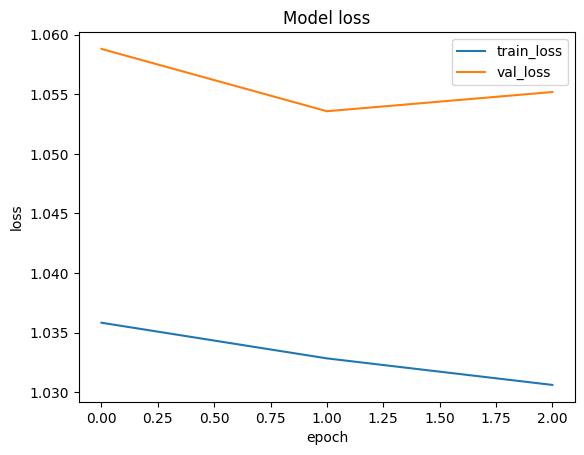

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

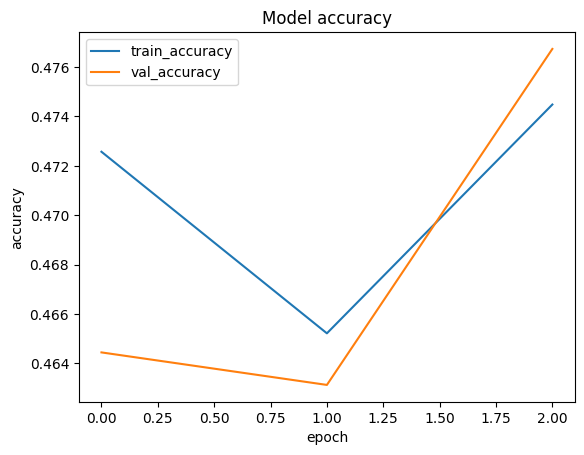

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

## Evaluation

In [ ]:
lenet_model.evaluate(val_dataset)

72/72 [==============================] - 3s 37ms/step - loss: 0.7697 - accuracy: 0.7151 - top_k_accuracy: 0.8859


[0.7696886658668518, 0.7151009440422058, 0.885864794254303]

In [ ]:
resnet_34.evaluate(val_dataset)

72/72 [==============================] - 4s 52ms/step - loss: 1.0552 - accuracy: 0.4767 - top_k_accuracy: 0.7792


[1.055187702178955, 0.4767339825630188, 0.7791922688484192]

In [ ]:
#loading best model
resnet_34.load_weights('best_weights')
resnet_34.evaluate(val_dataset)

72/72 [==============================] - 3s 38ms/step - loss: 1.0552 - accuracy: 0.4767 - top_k_accuracy: 0.7792


[1.0551880598068237, 0.4767339825630188, 0.7791922688484192]

## Testing

In [ ]:
test_image1 = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/110020.jpg")
im1 = tf.expand_dims(tf.constant(test_image1,dtype=tf.float32),axis=0)
test_image2=cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/angry/130322.jpg_rotation_1.jpg")
im2 = tf.expand_dims(tf.constant(test_image2,dtype=tf.float32),axis=0)
CLASS_NAME[tf.argmax(lenet_model(im1),axis=-1).numpy()[0]]
CLASS_NAME[tf.argmax(lenet_model(im2),axis=-1).numpy()[0]]

'angry'

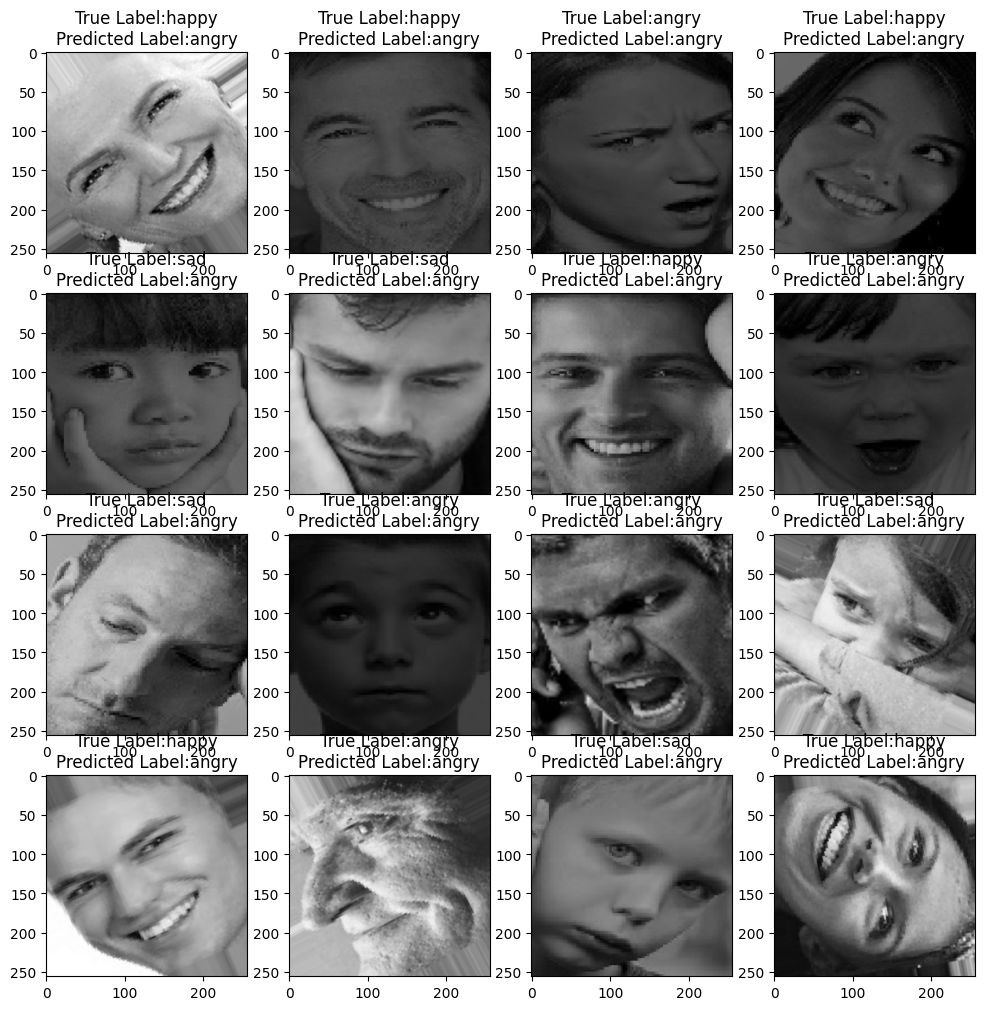

In [ ]:
plt.figure(figsize=(12,12))
for images,labels in val_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255)
    plt.title("True Label:"+CLASS_NAME[tf.argmax(labels[i],axis=0).numpy()]+"\n"+"Predicted Label:"+CLASS_NAME[tf.argmax(lenet_model(tf.expand_dims(images[i],axis=0))).numpy()[0]])


## Confusion Matrix

In [ ]:
predicted = []
labels = []
for im,label in val_dataset:
  predicted.append(lenet_model(im))
  labels.append(label.numpy())


In [ ]:
print(np.concatenate([np.argmax(labels[:-1],axis=-1).flatten(),np.argmax(labels[-1],axis=-1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1],axis=-1).flatten(),np.argmax(predicted[-1],axis=-1).flatten()]))


[1 1 1 ... 1 1 0]
[1 1 0 ... 1 1 0]


In [ ]:
pred = np.concatenate([np.argmax(predicted[:-1],axis=-1).flatten(),np.argmax(predicted[-1],axis=-1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1],axis=-1).flatten(),np.argmax(labels[-1],axis=-1).flatten()])

[[282 108 125]
 [ 74 818 114]
 [ 95 133 529]]


Text(0.5, 58.7222222222222, 'Predicted')

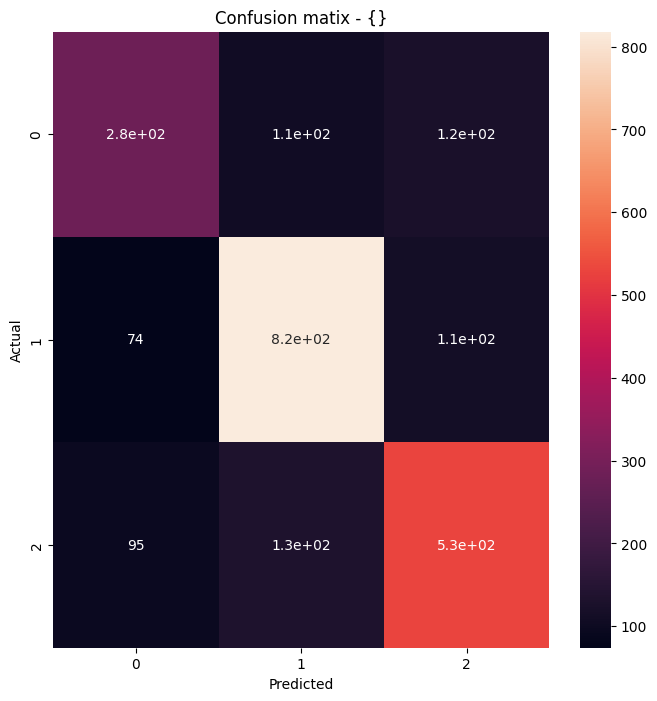

In [ ]:
cm = confusion_matrix(lab,pred)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm,annot=True)
plt.title('Confusion matix - {}')
plt.ylabel('Actual')
plt.xlabel('Predicted')

#TFRecords

In [ ]:
training_dataset = (
    training_dataset
    .unbatch()
)
validation_dataset = (
    validation_dataset
    .unbatch()
)

In [ ]:
training_dataset

<_UnbatchDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(3,), dtype=tf.float32, name=None))>

In [ ]:
validation_dataset

<_UnbatchDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(3,), dtype=tf.float32, name=None))>

In [ ]:
def create_example(image,label):
  int_feature = Feature(
      int64_list = Int64List(value=[label]))
  bytes_feature = Feature(
      bytes_list = BytesList(value=[image]))

  example = Example(
      features = Features(feature={
          "labels":int_feature,
          "images":bytes_feature
      }))

  return example.SerializeToString()

In [ ]:
NUM_SHARDS = 10
PATH = 'tfrecords/shard_{:02d}.tfrecord'

In [ ]:
# changing image to bytes format
def encode_image(image,label):
  # converting the image into uint8
  image = tf.image.convert_image_dtype(image,dtype=tf.uint8)
  image = tf.io.encode_jpeg(image)
  return image,tf.argmax(label)

In [ ]:
#
#for att in dir(training_dataset):
#     print(att, getattr(training_dataset,att))

In [ ]:
encoded_dataset = (
    training_dataset
    .map(encode_image)
)

In [ ]:
for shard_number in range(NUM_SHARDS):
  sharded_dataset = (
      encoded_dataset
      .shard(num_shards=NUM_SHARDS,index=shard_number)
      .as_numpy_iterator())
  with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
    for encoded_img,encoded_label in sharded_dataset:
      file_writer.write(create_example(encoded_img,encoded_label))

NotFoundError: ignored

In [ ]:
l = [PATH.format(p) for p in range(NUM_SHARDS)]

In [ ]:
reconstructed_dataset = tf.data.TFRecordDataset(filenames=l)

In [ ]:
# parsing tfrecords back to image
def parse_tfrecords(example):
  feature_description = {
      "images":tf.io.FixedLenFeature([],tf.string),
      "labels":tf.io.FixedLenFeature([],tf.int64),
  }
  example = tf.io.parse_single_example(example,feature_description)
  example["images"] = tf.io.decode_jpeg(example["images"],channels=3)

  return example["images"],example["labels"]


In [ ]:
parsed_dataset = (
  reconstructed_dataset
  .map(parse_tfrecords)
  .batch(CONFIGURATION["BATCH_SIZE"])
  .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
for i in parsed_dataset.take(1):
  print(i)

## Training with parsed data

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
sparse_acc = [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]

In [ ]:
lenet_model.compile(
    optimizer = Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]),
    loss = loss_fn,
    metrics = sparse_acc
)

In [ ]:
History = lenet_model.fit(
    parsed_dataset,
    epochs=3,
    verbose=1
)